In [1]:
# Importar as bibliotecas

import pandas as pd
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from textblob import TextBlob
from wordcloud import WordCloud
import seaborn as sns
%matplotlib inline

## Lendo o dataset

In [2]:
df0 = pd.read_csv('Bitcoin_tweets.csv')
df0.info()

/home/ffreller/.conda/envs/teste1/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (4,5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830476 entries, 0 to 2830475
Data columns (total 13 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_name         object
 1   user_location     object
 2   user_description  object
 3   user_created      object
 4   user_followers    object
 5   user_friends      object
 6   user_favourites   object
 7   user_verified     object
 8   date              object
 9   text              object
 10  hashtags          object
 11  source            object
 12  is_retweet        object
dtypes: object(13)
memory usage: 280.7+ MB


In [3]:
# Ficar apenas com a coluna com o conteúdo do tweet e sua data
df1 = df0[['text', 'date']].copy()

# Dropando linhas sem informação
df1.dropna(subset=["text"], inplace=True)

In [4]:
print(f"{len(df0) - len(df1)} linhas foram removidas")

138 linhas foram removidas


## Limpando o texto

In [5]:
# Função para limpar o texto do tweet
def clean_text(txt):
    txt = re.sub('#', '', txt) # remove simbolo '#'
    txt = re.sub('@[A-Za-z0-9]+', '', txt) # remove qualquer string que começa com '@' (menções)
    txt = re.sub('RT[\s]+', '', txt) # remove indicador de retweet
    txt = re.sub('\\n', ' ', txt) # tira '\n' do texto e substitui por espaço
    txt = re.sub('https?:\/\/\S+', '', txt) # tira links
    return txt        

In [6]:
df1['cleaned_text'] = df1['text'].apply(clean_text)

## Polaridade e subjetividade

In [7]:
%%time
#Criando coluna com a subjetividade do tweet
df1['subjectivity'] = df1['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

#Criando coluna com a polaridade do tweet
df1['polarity'] = df1['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

CPU times: user 15min 41s, sys: 795 ms, total: 15min 42s
Wall time: 15min 42s


In [8]:
# Salvando para não precisar rodas as funções acima, que demoram, toda vez que rodar o notebook
df1.to_pickle('sentiment_dataset.pkl')

### Sentimento a partir da polaridade

In [10]:
#Função para imputar sentiment negativo, neutro e positivo a partir da polaridade do tweet
def analyse_polarity(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
df1['sentiment'] = df1['polarity'].apply(analyse_polarity)

Positive    51.16%
Neutral     37.48%
Negative    11.37%
Name: sentiment, dtype: object

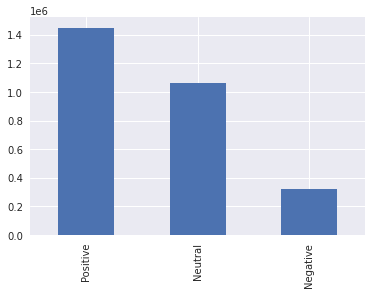

In [11]:
df1['sentiment'].value_counts().plot(kind='bar')
df1['sentiment'].value_counts(1).map('{:.2%}'.format)

De acordo com a análise, quase 50% dos tweets sobre bitcoin foram positivos. Os negativos respondem por pouco mais de 11%

## Nuvem de palavras

(-0.5, 799.5, 399.5, -0.5)

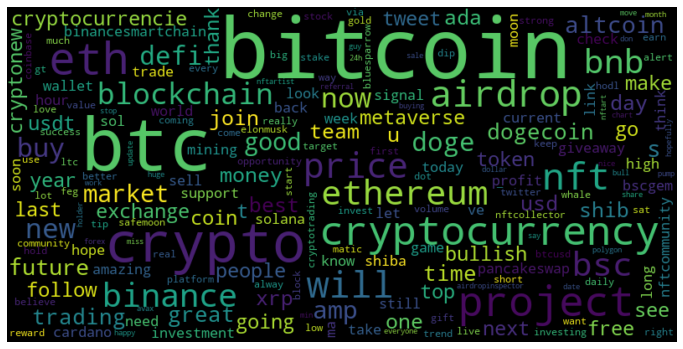

In [12]:
# Nuvem de palavras
all_words = ' '.join([text.lower() for text in df1['cleaned_text']])
wc = WordCloud(max_font_size=100, width=800, height=400, random_state=42, collocations=False).generate(all_words)
plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

Na núvem de palavras acima, vemos que os tweets sobre bitcoin trazem também algumas outras palavras com frequência. Ganharam destaques: o indicador de bitcoin no mercado ('btc'); a tecnologia por trás do bitcoin (blockchain); referências a criptomoedas (crypto, cryptocurrency); outras moedas (BTH) e outras aplicações de blockchain(nft); além de termos associados a sua venda e compra (buy, sell, market, signal, price, money)

## Correlação

<AxesSubplot:xlabel='polarity', ylabel='subjectivity'>

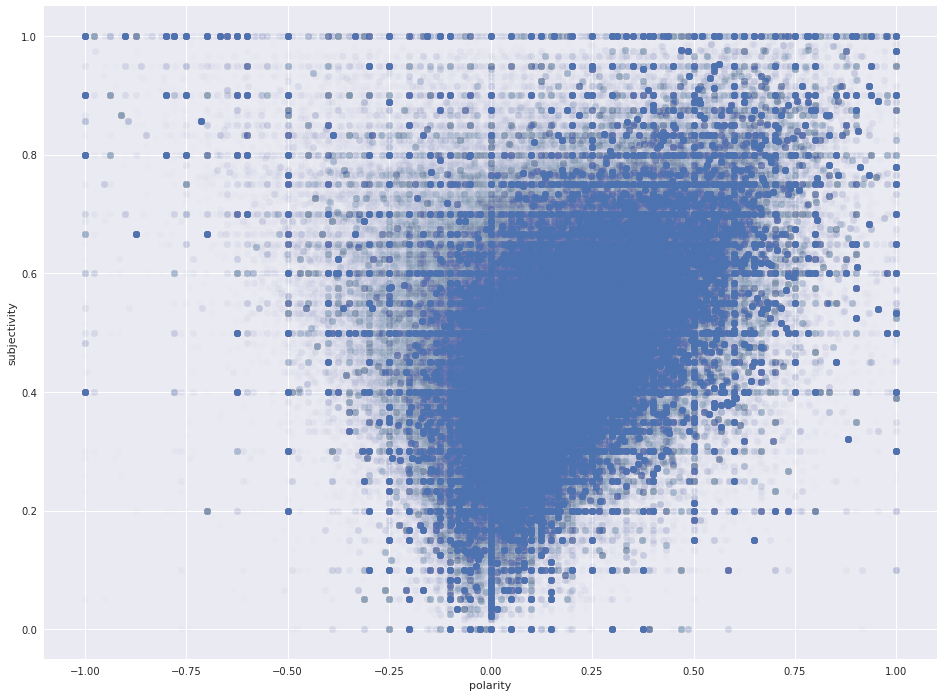

In [9]:
# Gráfico de polaridade vs subjetividade
plt.figure(figsize=(16,12))
sns.scatterplot(x='polarity', y='subjectivity', data=df1, alpha=0.01)

Olhando o gráfico de polaridade vs subjetividade, percebe-se que há uma correlação positiva entre os dois.

In [13]:
corr = df1[['subjectivity', 'polarity']].corr().iloc[0, -1]
print(f"A correlação entre subjetividade e polaridade é de {corr:.3f}")

A correlação entre subjetividade e polaridade é de 0.457


Observamos uma alta correlação entre a subjetividade e a polaridade no dataset. Isso nos indica que, conforme os tweets são mais subjetivos, eles tendem, neste conjunto de dados, a serem também mais positivos. Ou seja, dentre esses tweets, um aumento na subjetividade indica aumento na percepção positiva sobre o bitcoin.

## Sentimento ao longo do tempo

In [14]:
##Tratando coluna da data
df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [16]:
#Criando dummies da coluna de sentimento
df2 = df1.merge(pd.get_dummies(df1['sentiment'], prefix='sentiment'), left_index=True, right_index=True)
#Criando dataset agrupado por dia
df2 = df2[['sentiment_Negative', 'sentiment_Neutral', 'sentiment_Positive', 'subjectivity', 'polarity']].groupby(df2['date'].dt.date).mean()

<AxesSubplot:xlabel='date', ylabel='subjectivity'>

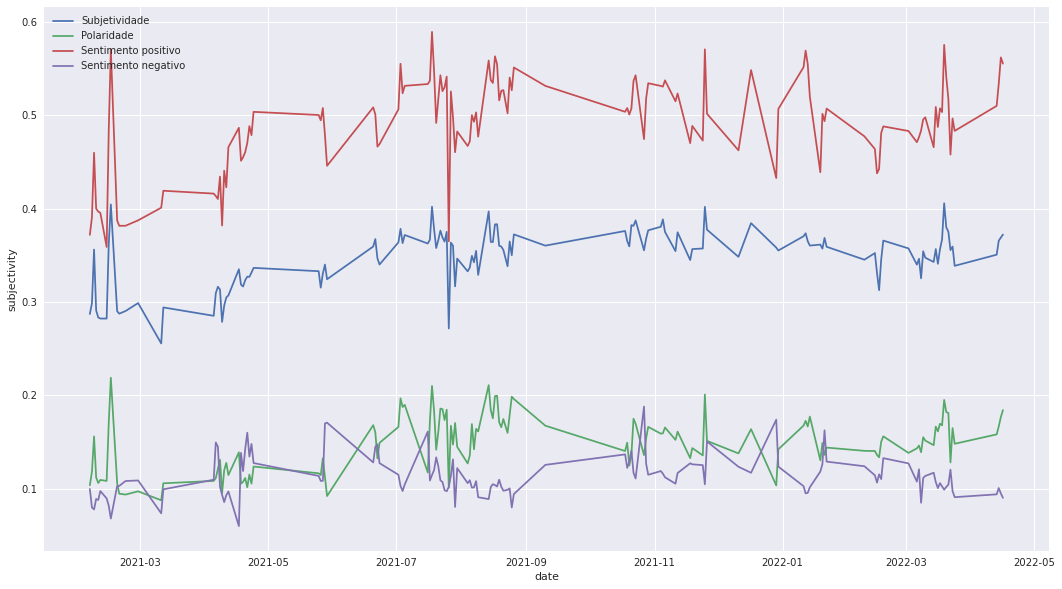

In [17]:
plt.figure(figsize=(18,10))
sns.lineplot(x=df2.index, y=df2['subjectivity'], label="Subjetividade")
sns.lineplot(x=df2.index, y=df2['polarity'], label="Polaridade")
sns.lineplot(x=df2.index, y=df2['sentiment_Positive'], label="Sentimento positivo")
sns.lineplot(x=df2.index, y=df2['sentiment_Negative'], label="Sentimento negativo")

O gráfico acima traz o valor médio de subjetividade e positividade em cada dia em que houve postagem. Além disso, há as curvas referentes ao sentimento positivo e negativo, que representam a proporção da prenseça sentimentos (positivos e negativos) entre os tweets publicados em cada dia

Pode-se notar como as curvas de subjetividade e de sentimento positivo caminham juntas, diferentemente da curva de sentimento negativo, que permanece relativamente estável durante o período. Isso apoia a hipótese de que uma variação na subjetividade dos tweets está correlacionada com a positividade destes.

Vale destacar que é possível observar uma variação considerável, ao longo do tempo, na subjetividade e no sentimento positivo. Essas informações podem ser úteis em algumas ocasiões em que o objetivo é aferir o sentimento do mercado em relação ao bitcoin. Os dados indicam que monitorar reações positivas pode ser mais efetivo do que monitorar as negativas, já que as primeiras têm maior variação ao longo do tempo.